<a href="https://colab.research.google.com/github/mapzine123/machine-running/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_%EC%8B%A0%EA%B2%BD%EB%A7%9D_%EB%AA%A8%EB%8D%B8_%ED%9B%88%EB%A0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# keyword : 드롭아웃, 콜백, 조기종료, 모델 저장, 불러오기
<br>
드롭아웃 : 은닉층에 있는 뉴런의 층을 랜덤하게 꺼서 과대적합을 막는 기법<br>
콜백 : 케라스 모델을 훈련하는 도중에 어떤 작업을 수행하도록 도와주는 도구<br>
-- ModelCheckpoint : 케라스 모델과 가중치를 일정 간격으로 저장<br>
-- EarlyStopping : 관심 지표가 더이상: 향상하지 않으면 훈련을 중지<br>
save_weight : 모등 층의 가중치와 절편 저장<br>
load_weights : 모든 층의 가중치와 절편을 파일에 읽음<br>
save : 모델의 구조와 모든 가중치, 절편을 저장<br>
load_model : save로 저장된 모델을 잃어옴<br>
<br>
Numpy.argmax : 배열에서 축에 따라 최대값의 인덱스를 반환

## 손실 곡선

In [ ]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# 모델 만들기
def model_fn(a_layer=None) :
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))
  model.add(keras.layers.Dense(100, activation='relu'))

  # 케라스 층을 추가하면 은닉층 뒤에 또 하나의 층을 추가
  if a_layer :
    model.add(a_layer)

  model.add(keras.layers.Dense(10, activation='softmax'))

  return model

In [ ]:
model = model_fn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 모델 훈련하고 fit메서드의 결과를 history 변수에 담기
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)
# verbose : 훈련 과적 출력 조절
# default값은 1,진행 막대와 손실 등의 지표가 출력됨
# 2로 바꾸면 진행 막대를 출력
# 0으로 지정하면 훈련 과정을 나타내지 않음

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


손실과 정확도가 포함되어 있음

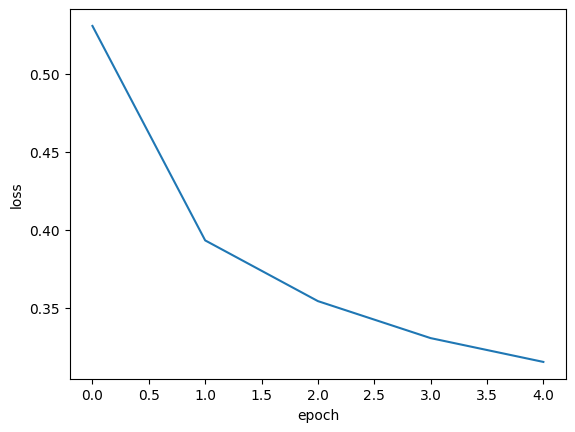

In [ ]:
# 손실과 정확도를 그래프로 시각화
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

손실값 그래프

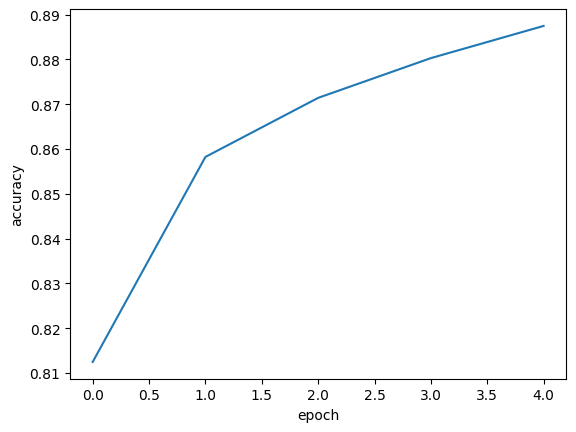

In [ ]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

정확도 그래프<br>
에포크마다 정확도는 증가하고 손실은 감소함

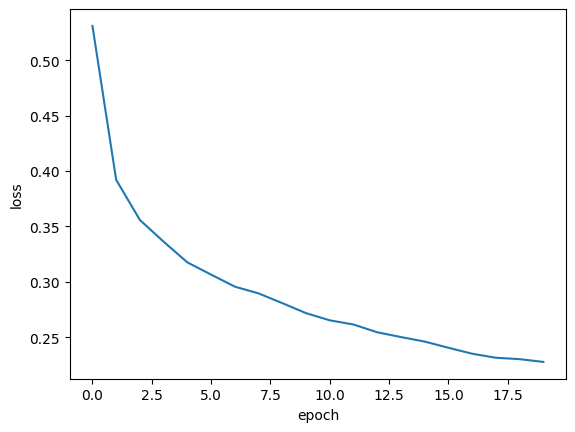

In [ ]:
# 에포크를 늘리고 손실그래프 그려보기
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

손실이 잘 감소하긴 하지만...

## 검증 손실

In [ ]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


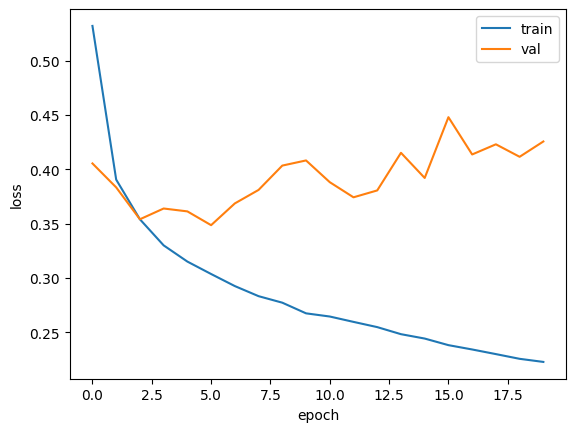

In [ ]:
# 그래프 그리기
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

검증세트에서 3번째 에포크 이후로 조금씩 로스가 증가하는 것을 볼 수 있음<br>
전형적인 ***과대 적합*** 모델<br>
옵티마이저 하이퍼파라미터를 주정해 과대적합을 완화시킬 수 있을까?<br>
<br>
기본적으로 RMSprop 옵티마이저가 설정되어있음<br>
다른 옵티마이저를 테스트한다면 ***Adam*** 이 좋음<br>
Adam은 적응적 학흡률을 사용해 에포크가 진행되면서 학습률의 크기를 조정할 수 있음

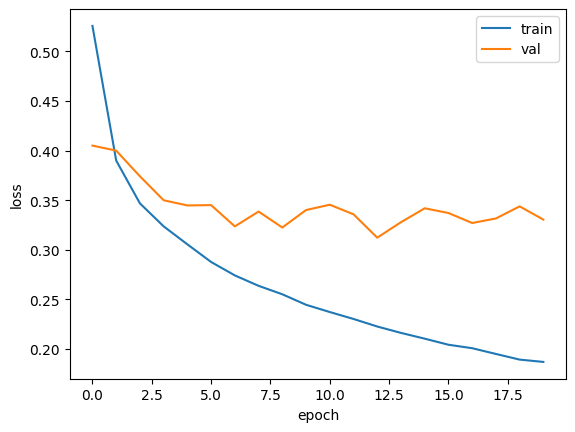

In [ ]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

조금은 과대적합이 해소된 모습

## 드롭아웃
훈련 과정에서 층에 있는 일부 뉴런들을 랜덤하게 꺼서(뉴런의 출력을 0으로 만들어서) 과대적합을 막음

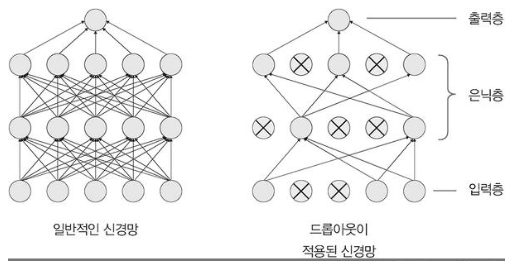

이전 층의 일부 뉴런이 랜덤하게<br>
1. 특정 뉴런에 과대하게 의존하는 것을 줄일 수 있음
2. 모든 입력에 대해 주의를 기울여야 함
3. 일부 뉴런의 출력이 없을 수 있다는걸 감안하면 신경망은 더 안정적인 예측을 만들 수 있을 것임
4. 드롭 아웃을 적용해 훈련하는 것은 마치 2개의 신경망을 앙상블 하는 것처럼 볼 수 있음

In [ ]:
# Dropout을 추가해서 모델 만들기
model = model_fn(keras.layers.Dropout(0.3))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


훈련이 끝난 뒤에 평가나 예측을 수행할 때는 드롭아웃을 적용하지 말아야함<br>
텐서플로우와 케라스는 모델의 평가와 예측에는 드롭아웃을 적용하지 않음

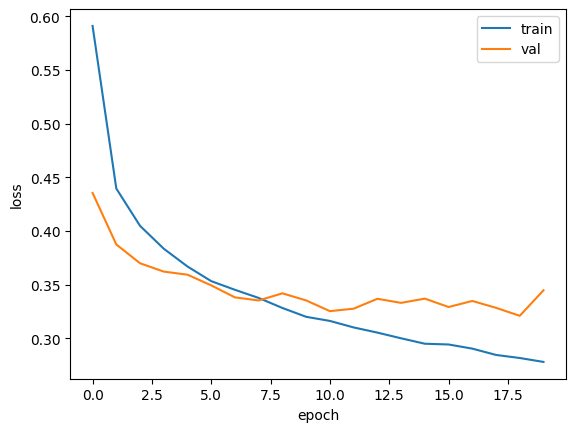

In [ ]:
# 훈련 손실과 검증 손실의 그래프 그려보기
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 모델 저장과 복원


In [ ]:
# 에포크를 10으로 지정하고 다시 모델 학습
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=10, verbose=0, validation_data=(val_scaled, val_target))

훈련된 모델의 파라미터를 저장하는 save_weight() 메서드가 있음<br>
텐서플로우의 체크포인트 포멧으로 저장함<br>
파일의 확장자가 .h5 일 경우 HDF5 포맷으로 저장

In [ ]:
# HDF5 포맷으로 저장
model.save_weights('model-weights.h5')

모델 구조와 모델 파라미터를 함께 저장하는 save 매서드도 있음

In [ ]:
# 모데 구조, 모델 파라미터 저장
model.save('model_whole.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# 파일 저장됐는지 확인
!ls -al *.h5

-rw-r--r-- 1 root root 333320 Jul 16 12:26 model-weights.h5
-rw-r--r-- 1 root root 981176 Jul 16 12:28 model_whole.h5


In [ ]:
# 모델 불러와서 사용

# 훈련되지 않은 새로운 모델 만들기
model = model_fn(keras.layers.Dropout(0.3))

# 저장한 모델 불러오기
model.load_weights('model-weights.h5')

load_weight 메서드를 사용하려면 save_weight로 저장했던 모델과 정확하게 같은 구조를 가지고 있어야함

MNIST 데이터셋이 다중 분류이기 때문에, keras의 pridict 메서드는 샘플마다 10개의 클래스에 대한 확률을 반환함<br>
MNIST 데이터셋에서 덜어낸 검증 세트의 수는 12,000개니까 predict 메서드는 (12,000, 10)의 배열을 반환 <br>
<br>
10개의 확률중 가장 큰 값을 골라 타깃 레이블과 비교하여 정확도를 계산<br>
evaluate 메서드를 사용해 정확도를 출력할 수도 있지만, 이 메서드는 손실을 계산하기 위해 반드시 먼저 compile 메서드를 실행해야함<br>
여기서는 새로운 데이터에 대한 정확도만 계산하는 상황

In [ ]:
import numpy as np
val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))

375/375 [==============================] - 1s 3ms/step
0.88075


argmax() : 배열에서 가장 큰 값의 인덱스를 반환
axis=-1 : 배열의 마지막 차원을 따라 최댓값을 고름

In [ ]:
# 모델구조, 모델 파라미터까지 다 저장한 모델로 정확도 출력
model = keras.models.load_model('model_whole.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 2s 5ms/step - loss: 0.3305 - accuracy: 0.8808


[0.3304533362388611, 0.8807500004768372]

load_model 메서드는 모델 파라미터 뿐 아니라 모델 구조, 옵티마이저 상태까지 모두 복원하기 때문에 evaluate 메서드를 사용할 수 있음<br>
텐서플로우 2.3에서는 load_model함수의 버그 때문에 evaluate()를 사용하기 전에 compile 메서드를 호출해야함

## 콜백(Callback)
훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체<br>
ModelCheckpoint 콜백은 에포크마다 모델을 저장함<br>
save_best_only=True 매개변수를 이용해 가장 낮은 검증 점수를 만드는 모델을 저장할 수 있음

In [ ]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 체크포인트 콜백 함수 설정
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)

# 모델 훈련
model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target), callbacks=(checkpoint_cb))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# 최상의 검증 점수를 낸 모델을 불러와서 예측 수행
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3190 - accuracy: 0.8890


[0.3190203309059143, 0.8889999985694885]

## 조기종료 (early stopping)
검증 점수가 상승하기 시작하면 그 이후에는 과대적합이 커지기 때문에 훈련을 계속 할 필요가 없음<br>
이때 훈련을 중지하면 컴퓨터 자원을 아낄 수 있음<br>
이렇게 과대적합이 시작되기 전에 훈련을 미리 중지하는 것을 ***조기 종료*** 라고 함<br><br>
조기 종류는 훈련 에포크 횟수를 제한하는 역할이지만, 모델이 과대적합 되는 것을 막아주기 때문에 규제 방법 중 하나라고도 생각할 수 있음<br>
<br>
keras에는 EarlyStopping 콜백이 있음<br>
partience 매개변수로 검증 점수가 향상하지 않아도 참을 에포크 횟수 지정 가능<br>
restore_best_weights 매개변수를 True로 설정하면 가장 낮은 검증 손실을 낸 모델 파라미터로 되돌림


In [ ]:
# checkpoint 콜백과 early stopping 콜백 사용
model = model_fn(keras.layers.Dropout(0.3))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# checkpoint 콜백
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)

# earlyStopping 콜백
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

# 모델 훈련
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target), callbacks=(checkpoint_cb, early_stopping_cb))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# 몇번째 에포크에서 멈췄는지 확인
print(early_stopping_cb.stopped_epoch)

11


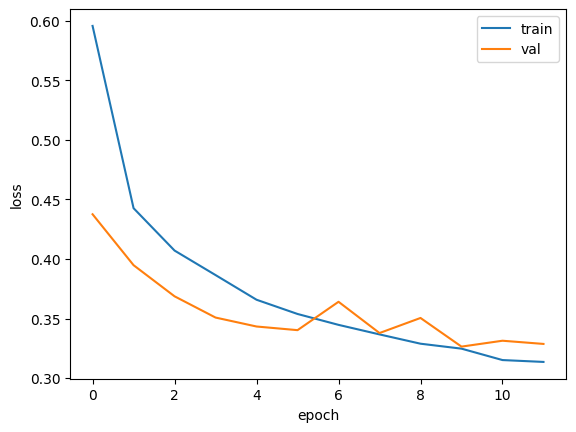

In [ ]:
# 훈련 손실과 검증 손실 그래프 그려보기
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

조기 종료 기법을 사용하면 안심하고 에포크 횟수를 크기 지정해도 상관없음<br>
ModelCheckpoint 콜백과 EarlyStopping 콜백을 함께 사용하면 최상의 모델을 자동으로 저장해 주니까 편리함

In [ ]:
# 조기 종료로 얻은 모델을 사용해 검증 세트에 대한 성능 확인
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 2s 4ms/step - loss: 0.3264 - accuracy: 0.8769


[0.326415091753006, 0.8769166469573975]